<a href="https://colab.research.google.com/github/smahesh2694/NEU_XAI/blob/master/LG_report1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**XAI Project Report** 

Visual defect inspection is of paramount importance during quality assurace and quality control in all manufacturing industries. This project aims to investigate an interpretable visual inspection framework for surface defect identification on hot-rolled steel strips. A classification model is built on the recommended open source steel visual defect dataset from the North-Eastern University, China called ‘NEU surface defect database’. As the accuracy obtained are satisfactory, two model-agnostic XAI approaches namely LIME and SHAP, are implemented on the trained model treating it to be a 'blackbox', and the results obtained over the period, are attached in this report for LG's perusal. This project is built on Keras with tensorflow as backend. For defect classification purpose, transfer learning is implemented using 'MobileNet' model pre-trained on ImageNet dataset (14 million images). 


 ***


#**Dataset**

NEU surface defect dataset ([NEU](http://faculty.neu.edu.cn/yunhyan/NEU_surface_defect_database.html)) has 6 classes of defects commonly found in steel strips, namely 

1.   Rolled-in scale (RS)
2.   Patches (Pa)
3.   Crazing (Cr)
4.   Pitted surface (PS)
5.   Inclusion (In)
6.   Scratches (Sc)

With 300 images on each class of defect, the dataset has a total of 1800 defective images. All images are grayscale and are of dimension 200x200. A screenshot of images from the dataset, across all classes of defects are attached below.

<figure>
<center>
<img src='https://drive.google.com/uc?id=1ywt-hDfWYt9kMM4yYFXZQfMvpnjLXsiv' width=300 height=300/>
<figcaption>Classes in NEU dataset</figcaption></center>
</figure>

The dataset also has ground truth annotation of the bounding boxes which is to be utilised for evaluating the accuracy of the XAI approach chosen. The challenge with the images in the dataset can be inferred by observation. 

*   Interclass defect similarity
*   Intraclass defect variation

********












#**Model**

MobileNet model is used as the base model and its pre-trained weights are imported. As the model is loaded, the “include_top” argument is set to 'False', so the fully-connected output layers of the model used to make predictions is not included, allowing us to add and train a new output layer. Thus, transfer learning is implemented and all necessary packages are imported.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import os
import keras
import cv2
import seaborn as sn
import matplotlib.pyplot as plt
from keras.layers.core import Dense
from keras.layers import GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.optimizers import SGD
from sklearn import preprocessing
from skimage.segmentation import mark_boundaries
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from xml.etree import ElementTree

In [0]:
base_model=MobileNet(weights='imagenet',include_top=False) 

A custom output layer which suits our NEU surface defect dataset is built on the top of the base_model (MobileNet). After the GlobalAveragePooling2D layer, a dense layer with 'relu' activation is added which is fed into a softmax layer with 6 [ ] as per the number of classes.

In [0]:
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(512,activation='relu')(x) 
preds=Dense(6,activation='softmax')(x)

In [0]:
model=Model(inputs=base_model.input, outputs=preds)

In [0]:
model.summary()

We start by freezing all of the base model’s layers, as we are trying to leverage the knowledge learned by the network from ImageNet dataset. By setting the base_model.trainable=False , the weights of the base_model are not updated during the training process.

In [0]:
base_model.trainable = False 

**Data Loading**

A split of 10 percent from each class is done randomly as test images. The model is not trained on these 180 images and so they are used to access the accuracy of the model's prediction. From the available 90 percent of data, a validation split of 20 percent is done as per standard procedure. The data is fed into the network for training through keras' flow_from_directory function with a batch size of 16. Also, the label_map of the model is retrieved from the generator.

In [0]:
train_datagen=ImageDataGenerator(rescale=1./255,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True, 
                                 validation_split=0.2)

In [8]:
bs = 16
train_generator=train_datagen.flow_from_directory('/content/drive/My Drive/NEU surface defect database - test split/Train',  
                                                 target_size=(200,200),     
                                                 batch_size=bs,
                                                 class_mode='categorical',                                                 
                                                 shuffle=True,
                                                 subset='training')

Found 1296 images belonging to 6 classes.


In [9]:
train_generator.image_shape

(200, 200, 3)

In [10]:
label_map = (train_generator.class_indices)
print(label_map)

{'Cr': 0, 'In': 1, 'PS': 2, 'Pa': 3, 'RS': 4, 'Sc': 5}


Similar to the training process, a generator for validation is built. Using 'categorical_crossentropy' as the loss function and [SGD] optimizer, the model is complied. 

In [11]:
val_generator=train_datagen.flow_from_directory('/content/drive/My Drive/NEU surface defect database - test split/Train', 
                                                 target_size=(200,200),  
                                                 batch_size=bs,
                                                 class_mode='categorical',
                                                 shuffle=True,
                                                 subset='validation')

Found 324 images belonging to 6 classes.


In [12]:
model.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=['acc'])

In [0]:
#model.summary()

In [13]:
step_size_train = train_generator.n//train_generator.batch_size
print(step_size_train)
step_size_val = (val_generator.n//val_generator.batch_size)+1
print(step_size_val)

81
21


**Training**

With 25 initial epochs, the built model is fitted using fit_generator function with step sizes of 81 and 21, for training and validation respectively. The validation accuracy is observed to be high from the first epoch, as []. The fitted model is evaluated with 99.6875 percent validation accuracy.

In [0]:
initial_epochs = 25

In [16]:
history = model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   validation_data=val_generator,
                   validation_steps=step_size_val,                
                   epochs=initial_epochs)

Epoch 1/25
81/81 [==============================] - 744s 9s/step - loss: 0.2889 - acc: 0.9128 - val_loss: 0.0368 - val_acc: 0.9969
Epoch 2/25
81/81 [==============================] - 21s 264ms/step - loss: 0.0731 - acc: 0.9799 - val_loss: 0.0122 - val_acc: 0.9969
Epoch 3/25
81/81 [==============================] - 22s 269ms/step - loss: 0.0536 - acc: 0.9853 - val_loss: 0.0255 - val_acc: 0.9907
Epoch 4/25
81/81 [==============================] - 22s 268ms/step - loss: 0.0373 - acc: 0.9892 - val_loss: 0.0083 - val_acc: 1.0000
Epoch 5/25
81/81 [==============================] - 22s 270ms/step - loss: 0.0284 - acc: 0.9923 - val_loss: 0.0187 - val_acc: 0.9907
Epoch 6/25
81/81 [==============================] - 22s 267ms/step - loss: 0.0222 - acc: 0.9946 - val_loss: 0.0159 - val_acc: 0.9969
Epoch 7/25
81/81 [==============================] - 22s 266ms/step - loss: 0.0241 - acc: 0.9946 - val_loss: 0.0105 - val_acc: 0.9969
Epoch 8/25
81/81 [==============================] - 22s 270ms/step - lo

In [17]:
scores = model.evaluate_generator(generator=val_generator,
                         steps=step_size_val,verbose = 1)
print('Validating loss:', scores[0])
print('Validating accuracy:', scores[1])

21/21 [==============================] - 4s 187ms/step
Validating loss: 0.0054155703250284275
Validating accuracy: 0.9969135802469136


**Fine tuning**

In order to build the model robust, the last 1/3 rd layers of the model are fine tuned on the NEU dataset by setting 'True' label to the 'model.trainable' paramater.

In [0]:
base_model.trainable = True

In [19]:
no_layers = len(base_model.layers)
print("Number of layers in the base model: ", no_layers)

Number of layers in the base model:  87


In [0]:
fine_tune_at = (2 * no_layers)/ 3

In [0]:
for layer in base_model.layers[:int(fine_tune_at)]:
  layer.trainable =  False

In [0]:
model.summary()

With 15 more epochs for fine tuning at the depth layers, our model is trained again to get about 99.9 percent validation accuracy.

In [29]:
fine_tune_epochs = 15
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   validation_data=val_generator,
                   validation_steps=step_size_val,                
                   epochs=total_epochs,
                   initial_epoch = initial_epochs)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 26/40
81/81 [==============================] - 24s 291ms/step - loss: 0.0053 - acc: 0.9985 - val_loss: 0.0046 - val_acc: 0.9969
Epoch 27/40
81/81 [==============================] - 22s 268ms/step - loss: 0.0091 - acc: 0.9977 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 28/40
81/81 [==============================] - 22s 268ms/step - loss: 0.0031 - acc: 0.9992 - val_loss: 7.1989e-04 - val_acc: 1.0000
Epoch 29/40
81/81 [==============================] - 22s 267ms/step - loss: 0.0047 - acc: 0.9992 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 30/40
81/81 [==============================] - 22s 267ms/step - loss: 0.0060 - acc: 0.9977 - val_loss: 9.3192e-04 - val_acc: 1.0000
Epoch 31/40
81/81 [==============================] - 22s 269ms/step - loss: 0.0028 - acc: 0.9985 - val_loss: 0.0030 - val_acc: 1.0000
Epoch 32/40
81/81 [==============================] - 21s 265ms/step - loss: 0.0125 - acc: 0.9946 - val_loss: 0.0130 - val_acc: 0.9969
Epoch 33/40
81/81 [==============================] - 2

In [30]:
scores = model.evaluate_generator(generator=val_generator,
                         steps=step_size_val,verbose = 1)
print('Validating loss:', scores[0])
print('Validating accuracy:', scores[1])

21/21 [==============================] - 4s 190ms/step
Validating loss: 0.0006680976240754661
Validating accuracy: 1.0




---



# **Accuracy Plots**

The training accuracy (and loss) is plotted along validation accuracy (and loss) against the number of epochs to get the accuracy plot. In order to differentiate the initial training process from fine tuning, the plot is split with a green line for better interpretation of results.

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [0]:
acc += history_fine.history['acc']
val_acc += history_fine.history['val_acc']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

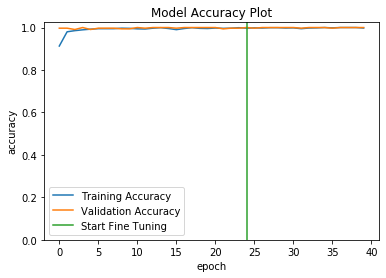

In [50]:
plt.figure(figsize=(6, 4))
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, max(plt.ylim())+0.02])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower left')
plt.title('Model Accuracy Plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

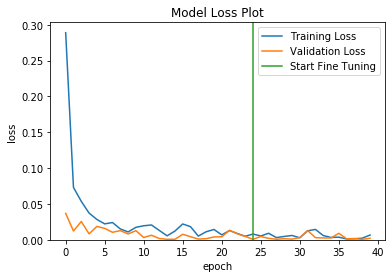

In [51]:
plt.figure(figsize=(6, 4))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, max(plt.ylim())])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Model Loss Plot')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()



---



# **Testing**

In order to test the model, it was made to predict the class on the test set (10 percent of original dataset which was untouched) using a test generator with a batch size of 1. By obtaining the prediction indices for each input test image, the classification report and the confusion matrix has been plotted to visualize the evaluation of the model.

In [0]:
test_datagen = ImageDataGenerator(rescale=1./255,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True)

In [115]:
test_generator = test_datagen.flow_from_directory('/content/drive/My Drive/NEU surface defect database - test split/Test',
                                                  target_size=(200,200),     
                                                  batch_size=1,
                                                  class_mode=None,
                                                  shuffle = False)

Found 180 images belonging to 6 classes.


In [116]:
step_size_test = test_generator.n//test_generator.batch_size
print(step_size_test)
test_generator.reset()

180


In [117]:
predIndxs = model.predict_generator(test_generator, steps = step_size_test, verbose=1 )
predIndxs = np.argmax(predIndxs, axis=1)

180/180 [==============================] - 3s 16ms/step


Predictions for each images are printed along its associated labels . The results can also be  exported and documented as a csv format file for further evaluation of model accuracy and precision.

In [125]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
print("Labels : ", labels)

predictions = [labels[k] for k in predIndxs]
print(predictions)

Labels :  {0: 'Cr', 1: 'In', 2: 'PS', 3: 'Pa', 4: 'RS', 5: 'Sc'}
['Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'Sc', 'Sc', 'Sc', 'Sc', 'Sc', 'Sc'

In [0]:
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv('/content/drive/My Drive/XAI_results/results2.csv',index=False)



---



# **Results Evaluation**


The classification report with metrics such as precision, recall and f-1 score [] is plotted for each individual classes. As the validation accuracy is about 99.7 percent, we obtain a 100 percent the test accuracy on all test images.





In [61]:
print(classification_report(test_generator.classes, predIndxs, target_names=test_generator.class_indices.keys()))

              precision    recall  f1-score   support

          Cr       1.00      1.00      1.00        30
          In       1.00      1.00      1.00        30
          PS       1.00      1.00      1.00        30
          Pa       1.00      1.00      1.00        30
          RS       1.00      1.00      1.00        30
          Sc       1.00      1.00      1.00        30

    accuracy                           1.00       180
   macro avg       1.00      1.00      1.00       180
weighted avg       1.00      1.00      1.00       180



The confusion matrix helps to visualize the predicted labels of our test images along the actaul ground truth labels. It can be noted that all test images have been correctly predicted by our model.

In [101]:
cm = confusion_matrix(test_generator.classes,predIndxs)
print(cm)

total = sum(sum(cm))
print("Total test images: ", total)
acc = (cm[0, 0] + cm[1, 1] + cm[2, 2] + cm[3, 3] + cm[4, 4] + cm[5, 5]) / total
print("Accuracy: {:.3f}".format(acc))
print("Lables:")
print("X : Predicted")
print("Y : Actual")

[[30  0  0  0  0  0]
 [ 0 30  0  0  0  0]
 [ 0  0 30  0  0  0]
 [ 0  0  0 30  0  0]
 [ 0  0  0  0 30  0]
 [ 0  0  0  0  0 30]]
Total test images:  180
Accuracy: 1.000
Lables:
X : Predicted
Y : Actual


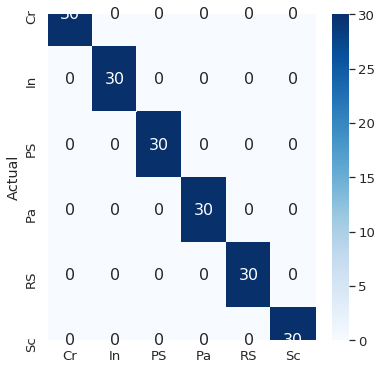

In [112]:
plt_cm = pd.DataFrame(cm, index=test_generator.class_indices.keys(), columns=test_generator.class_indices.keys())
plt_cm.index.name = "Actual"
plt_cm.index.columns = "Predicted"
plt.figure(figsize = (6,6))
sn.set(font_scale=1.2)
sn.heatmap(plt_cm, cmap="Blues", annot=True,annot_kws={"size": 16})

The model can also be saved and loaded at any instance to reduce the training time and to increase the efficiency for the end user.

In [0]:
#model.save('/content/drive/My Drive/xai_model/model.h5')

In [0]:
#saved_model = load_model('/content/drive/My Drive/xai_model/model.h5')



---



# **Prediction**

Given the path of the input image, the test_img is loaded and preprocessed as per the requirement for prediction function. Now the model predicts the probability of the image belonging to each class and the output is obtained by getting the maximum value of prediction and matching it with its associated labels. The order of the prediction probability is also noted as it helps us to visualize the super-pixels responsible for the preiction of each classes by comparing them with the explanation provided by LIME.



The ground truth annotation provided in the NEU dataset is exploited to visualize the bounding boxes for the defect region in the test images. They can be compared to the masks generated by LIME for each prediction to evaluate the accuracy and efficieny of the model built. 

In [0]:
annotation = '/content/drive/My Drive/NEU-DET/ANNOTATIONS/scratches_250.xml'
image_path = "/content/drive/My Drive/NEU surface defect database - test split/Test/Sc/Sc_250.bmp"

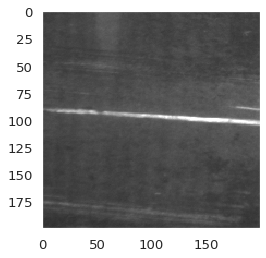

In [467]:
test_img = image.load_img(image_path)
plt.imshow(test_img)
plt.grid(None)

test_img = image.img_to_array(test_img)
test_img = np.expand_dims(test_img, axis=0)
test_img /= 255

In [468]:
labels = {0: 'Crazing', 1: 'Inclusion', 2: 'Pitted Surface', 3: 'Patches', 4: 'Rolled-in Scale', 5: 'Scratches'}

result = model.predict(test_img)
print(result)

prediction = result.argmax(axis=1)
print(prediction)

output = labels[int(prediction)]
print(output)

[[4.4245232e-07 1.7389544e-08 1.6696836e-07 5.0623743e-07 1.7379605e-07
  9.9999869e-01]]
[5]
Scratches


[[2, 82, 199, 107], [33, 175, 180, 197]]


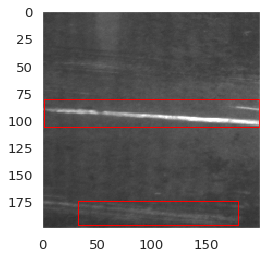

In [469]:
def extract_boxes(filename):
	tree = ElementTree.parse(filename)
	root = tree.getroot()	
	boxes = list()
	for box in root.findall('.//bndbox'):
		xmin = int(box.find('xmin').text)
		ymin = int(box.find('ymin').text)
		xmax = int(box.find('xmax').text)
		ymax = int(box.find('ymax').text)
		coors = [xmin, ymin, xmax, ymax]
		boxes.append(coors)
	return boxes 

b_img = cv2.imread(image_path)
boxes = extract_boxes(annotation)
print(boxes)

plt.grid(None)
for i in range(len(boxes)):
  pt1 = boxes[i][0], boxes[i][1]
  pt2 = boxes[i][2], boxes[i][3]
  cv2.rectangle(b_img, pt1, pt2, (255, 0, 0), 1)
  
  plt.imshow(b_img)

# LIME

Local Interpretable Model-agnostic Explanation (LIME) is a novel explanation technique that explains the prediction of any classifier by treating it as a 'blackbox' model, in an interpretable manner by learning an interpretable model locally around the prediction. LIME tests the variations in the predictions of the model with corresponding perturbations to the input data. So, LIME generates a new dataset for each input, consisting of permuted samples and its corresponding predictions. Then it trains an interpretable model which is weighted by the proximity of the sampled instances to the instance of interest. LIME now explains the predictions by intrepreting the local model. 



> LIME is pip installable and the necessary packages for the explanation of image classification are imported.



In [0]:
!pip install lime

In [458]:
%load_ext autoreload
%autoreload 2
import os, sys
import lime
from lime import lime_image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
explainer = lime_image.LimeImageExplainer()

The 'explain_instance' function gets the input test image and the model's prediction values and generates the masks in terms of super-pixels which are responsible for the classification of the test image to a particular class. By chnaging the 'top_labels' attribute, the number of masks to be generated for each test image is determined. It's assigned value 6 denotes the number of classes in our dataset.



> The explanation function takes about 6 secs for each image with GPU processing and it has been recorded to be about 10 minutes under normal CPU.


In [471]:
%%time

explanation = explainer.explain_instance(test_img[0], model.predict, top_labels=6, hide_color=0)

CPU times: user 5.1 s, sys: 1.28 s, total: 6.38 s
Wall time: 6.1 s


In [472]:
labels = {0: 'Crazing', 1: 'Inclusion', 2: 'Pitted Surface', 3: 'Patches', 4: 'Rolled-in Scale', 5: 'Scratches'};
print("Predictions: \n")
for i in range(len(explanation.top_labels)):
  rank = explanation.top_labels[i]
  print(i,labels[rank])  

Predictions: 

0 Scratches
1 Patches
2 Crazing
3 Rolled-in Scale
4 Pitted Surface
5 Inclusion


Given the order of the probability of prediction, the value of 'p' is set to visualize the patches responsible for its classification. 'p' set to 0 explains the top prediction by the model.

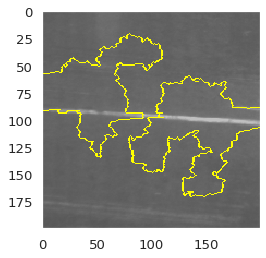

In [473]:
p = 0
temp, mask = explanation.get_image_and_mask(explanation.top_labels[p], positive_only=True, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.25, mask))
plt.grid(None)

To increase the interpretabilty of LIME, 'hide_rest' attribute is set to 'True' as it sets the values of pixels other than the chosen super-pixels to gray. 

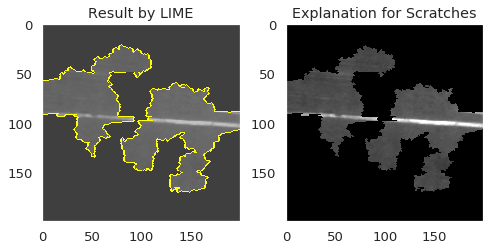

In [478]:
p = 0
temp, mask = explanation.get_image_and_mask(explanation.top_labels[p], positive_only=True, 
                                            num_features=10, hide_rest=True)
top = labels[explanation.top_labels[p]]
title = "Explanation for " + top

plt.figure(figsize=(8, 8))
plt.subplot(2,2,1)
plt.imshow(mark_boundaries(temp / 2 + 0.25, mask))
plt.title('Result by LIME')
plt.grid(None)

plt.subplot(2,2,2)
plt.imshow(temp)
plt.title(title)
plt.grid(None)

By changing the value of 'positive_only' attribute to False, we can get the pixels responsible for a particular classification to 'green' shade and the pixels which affects the classification to 'red' shade. It can be noted that the value of 'num_features' can be modified which is set as a complexity measure for minimising the loss function.

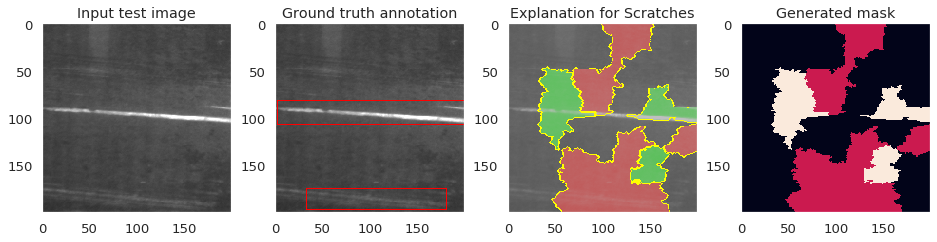

In [483]:
p = 0
temp, mask = explanation.get_image_and_mask(explanation.top_labels[p], positive_only=False, 
                                            num_features=10, hide_rest=False)
top = labels[explanation.top_labels[p]]
title = "Explanation for " + top

plt.figure(figsize=(16, 16))
plt.subplot(4,4,1)
plt.imshow(test_img[0])
plt.title('Input test image')
plt.grid(None)

plt.subplot(4,4,2)
plt.imshow(b_img)
plt.title('Ground truth annotation')
plt.grid(None)

plt.subplot(4,4,3)
plt.imshow(mark_boundaries(temp / 2 + 0.25, mask))
plt.title(title)
plt.grid(None)

plt.subplot(4,4,4)
plt.imshow(mask)
plt.title('Generated mask')
plt.grid(None)